In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [ ]:
# import master dataframe
master_df = pd.read_csv('data/master_df.csv')

# drop rows with NaN
master_df.dropna(how='any',axis=0, inplace=True) 

# drop index
master_df.drop(master_df.columns[0], axis=1, inplace=True)

# one hot encode days of the week, month
master_df = pd.get_dummies(master_df, columns=['DAY_OF_WEEK','MONTH'])

In [6]:
master_df.head()

,Lat,Long,HOUR,TAVG,PRCP,SNOW,closest_property_value,neighborhood_avg,lamp_min_dist,lamp_density,SHOOTING,UCR_PART,OFFENSE_DESCRIPTION,OFFENSE_CODE_GROUP,DAY_OF_WEEK_Friday,DAY_OF_WEEK_Monday,DAY_OF_WEEK_Saturday,DAY_OF_WEEK_Sunday,DAY_OF_WEEK_Thursday,DAY_OF_WEEK_Tuesday,DAY_OF_WEEK_Wednesday,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,42.259518,-71.121563,9,59.0,0.00,0.0,454000.0,4.406696e+05,0.001234,563.0,0,Part One,AUTO THEFT,Auto Theft,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,42.262092,-71.116710,20,56.0,0.01,0.0,541300.0,4.528877e+05,0.000539,531.0,0,Part One,AUTO THEFT,Auto Theft,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,42.352375,-71.135096,15,56.0,0.01,0.0,259900.0,5.895101e+05,0.000167,1272.0,0,Part One,AUTO THEFT - LEASED/RENTED VEHICLE,Auto Theft,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,42.349476,-71.076402,4,56.0,0.01,0.0,492000.0,1.666753e+06,0.000074,4461.0,0,Part One,AUTO THEFT,Auto Theft,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,42.381846,-71.066551,8,71.0,0.22,0.0,836900.0,6.054951e+05,0.000108,2672.0,0,Part One,AUTO THEFT - LEASED/RENTED VEHICLE,Auto Theft,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [10]:
# split into predictors and response
X = master_df.drop(['OFFENSE_CODE_GROUP','UCR_PART','OFFENSE_DESCRIPTION'], axis=1) 
y = master_df['OFFENSE_CODE_GROUP']

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [11]:
# fit logistic regression
logreg = LogisticRegression(C=100000, fit_intercept=True, solver='lbfgs')
logreg.fit(X_train.values, y_train.values);

In [12]:
accuracy_score(logreg.predict(X_train), y_train)

0.10383559573878662

In [6]:
pd.Series(logreg.predict(X_train)).value_counts()

Part Three    198161
dtype: int64

In [7]:
y_train.value_counts()

Part Three    99081
Part Two      60601
Part One      38479
Name: UCR_PART, dtype: int64

## Random Forest

In [8]:
depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, depths):

    # store output variables
    cvmeans      = []
    cvstds       = []
    train_scores = []
    
    # test different tree depths 
    for depth in depths:
        
        # create model
        dtree = DecisionTreeClassifier(max_depth=depth)
        
        # use k=5 cross validation to evaluate performance
        cv_scores = cross_val_score(dtree, X_train, y_train, cv=5)
        
        # store mean and std of cv scores
        cvmeans.append(np.mean(cv_scores))
        cvstds.append(np.std(cv_scores))
    
        # evaluate performance on training set
        dtree.fit(X_train,y_train)
        y_pred_train = dtree.predict(X_train)
        acc_score_train = accuracy_score(y_pred_train, y_train)
        train_scores.append(acc_score_train)
    
    # end of your code here
    return cvmeans, cvstds, train_scores

In [9]:
cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths)

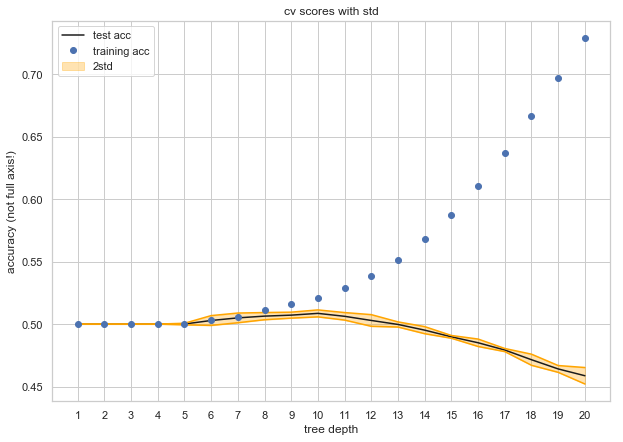

In [12]:
# initialize figure
fig = plt.figure(figsize=(10,7))

# get data for mean +/- 2std 
stdabove = np.array(cvmeans) + 2*np.array(cvstds)
stdbelow = np.array(cvmeans) - 2*np.array(cvstds)

# plot cvmeans and cvstds
plt.plot(cvmeans,'k',label='test acc')
plt.plot(stdabove,'orange')
plt.plot(stdbelow,'orange')

# fill in between space
plt.fill_between(range(len(cvmeans)),stdbelow,stdabove,color='orange',alpha=.3,label='2std')

# plot training scores
plt.plot(train_scores,'o',label='training acc')

# plot formatting
plt.title('cv scores with std')
plt.xlabel('tree depth')
# plt.ylim(0.54,0.7) # can set the y-axis to focus on the cross-validation performance
plt.xticks(range(0,20),range(1,21))
plt.ylabel('accuracy (not full axis!)')
plt.legend()
plt.show()

In [5]:
master_df.head()

,Lat,Long,HOUR,TAVG,PRCP,SNOW,closest_property_value,neighborhood_avg,lamp_min_dist,lamp_density,SHOOTING,UCR_PART,OFFENSE_DESCRIPTION,OFFENSE_CODE_GROUP,DAY_OF_WEEK_Friday,DAY_OF_WEEK_Monday,DAY_OF_WEEK_Saturday,DAY_OF_WEEK_Sunday,DAY_OF_WEEK_Thursday,DAY_OF_WEEK_Tuesday,DAY_OF_WEEK_Wednesday,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,42.259518,-71.121563,9,59.0,0.00,0.0,454000.0,4.406696e+05,0.001234,563.0,0,Part One,AUTO THEFT,Auto Theft,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,42.262092,-71.116710,20,56.0,0.01,0.0,541300.0,4.528877e+05,0.000539,531.0,0,Part One,AUTO THEFT,Auto Theft,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,42.352375,-71.135096,15,56.0,0.01,0.0,259900.0,5.895101e+05,0.000167,1272.0,0,Part One,AUTO THEFT - LEASED/RENTED VEHICLE,Auto Theft,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,42.349476,-71.076402,4,56.0,0.01,0.0,492000.0,1.666753e+06,0.000074,4461.0,0,Part One,AUTO THEFT,Auto Theft,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,42.381846,-71.066551,8,71.0,0.22,0.0,836900.0,6.054951e+05,0.000108,2672.0,0,Part One,AUTO THEFT - LEASED/RENTED VEHICLE,Auto Theft,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
